In [1]:
#pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [3]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [4]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [5]:
#Descriminartor
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [6]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [7]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = r"HR1/" 

for img in os.listdir(train_dir+"/HR/"):
    img_array = cv2.imread(train_dir +"/HR/"+ img)
    
    img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite("HR1/lr1/" + img, img_array)

In [15]:
from skimage import io
n=100
path1=r"HR1/lr1/"
path2=r"HR1/HR/"
lr_list = os.listdir(path1)[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(path1+img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir(path2)[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(path2 + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

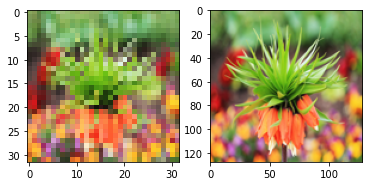

In [16]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [17]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,test_size=0.33, random_state=42)

In [18]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [19]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [20]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [21]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [22]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [23]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [24]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [35]:
epochs = 200
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:57,  1.15it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:01<00:29,  2.18it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:01<00:20,  3.07it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:01<00:16,  3.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:01<00:14,  4.38it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:12,  4.81it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:11,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:02<00:10,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:02<00:10,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:03<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:03<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:03<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:04<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:04<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:06<00:05,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:08<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:09<00:02,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.72it/s]


epoch: 1 g_loss: 28.143919788189788 d_loss: [1.56869139 0.96268657]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 2 g_loss: 27.906736758217882 d_loss: [1.1133046  0.97761194]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 3 g_loss: 25.604694921578933 d_loss: [0.0221683  0.99253731]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 4 g_loss: 25.841188686997143 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 5 g_loss: 24.348007743038348 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 6 g_loss: 21.695237529811575 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 7 g_loss: 21.647861836561518 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 8 g_loss: 21.891047975910244 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 9 g_loss: 22.299784489532016 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:05<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 10 g_loss: 20.779454302431933 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.09it/s]


epoch: 11 g_loss: 19.974371881627324 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  4.44it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  4.84it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:02,  5.16it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 12 g_loss: 19.10919286243951 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 13 g_loss: 20.44634618332137 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.03it/s]


epoch: 14 g_loss: 20.93425750732422 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 15 g_loss: 21.209889682371227 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 16 g_loss: 22.7781110450403 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:04,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:05<00:04,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.29it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:03,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:09<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.21it/s]


epoch: 17 g_loss: 21.01187046961998 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:09,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 18 g_loss: 20.113738216570955 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 19 g_loss: 19.047414950470426 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 20 g_loss: 18.83288327259804 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 21 g_loss: 18.362930959730004 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 22 g_loss: 18.351210900207064 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 23 g_loss: 18.535790906023625 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 24 g_loss: 17.74407561145612 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:14,  4.23it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:12,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:11,  5.07it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.32it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:07,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:06,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:05,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 25 g_loss: 17.392537401683295 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 26 g_loss: 17.506779763235976 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 27 g_loss: 17.277581940835983 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:04,  6.22it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]


epoch: 28 g_loss: 16.62164034060578 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.09it/s]


epoch: 29 g_loss: 17.178000891386574 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 30 g_loss: 17.161490817568197 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 31 g_loss: 17.233385441908197 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 32 g_loss: 16.00231615465079 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 33 g_loss: 15.333453641008974 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 34 g_loss: 16.96077222966436 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 35 g_loss: 16.534306170335455 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:04,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 36 g_loss: 16.38340114479634 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 37 g_loss: 16.601035936554865 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:04,  4.31it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:04,  4.70it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.03it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:03,  5.29it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.92it/s]


epoch: 38 g_loss: 20.681521543815954 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 39 g_loss: 23.010929463514643 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.09it/s]


epoch: 40 g_loss: 17.300804707541396 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:09,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:09,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:05<00:04,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:06<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 41 g_loss: 14.695427496041825 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 42 g_loss: 13.164693021062595 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 43 g_loss: 13.061325756471549 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 44 g_loss: 13.111067309308408 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 45 g_loss: 13.697711731070903 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 46 g_loss: 14.747335725755834 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 47 g_loss: 13.821094384833948 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 48 g_loss: 12.956955553880379 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 49 g_loss: 13.610907398053069 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  4.43it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 50 g_loss: 12.902216477180595 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.09it/s]


epoch: 51 g_loss: 13.152111053466797 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 52 g_loss: 13.51527112277586 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.14it/s]


epoch: 53 g_loss: 13.224099216176503 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 54 g_loss: 12.24728295340467 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 55 g_loss: 11.836461512010489 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 56 g_loss: 11.43117309684184 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 57 g_loss: 10.628500184016442 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 58 g_loss: 10.849781698255397 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 59 g_loss: 11.86277862805039 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 60 g_loss: 12.841241053680875 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.09it/s]


epoch: 61 g_loss: 12.60236034820329 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 62 g_loss: 11.642456659630163 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 63 g_loss: 10.985497254044262 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:06,  4.34it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:05,  4.67it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:05,  4.99it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.22it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 64 g_loss: 11.016084898763628 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 65 g_loss: 11.047756572267902 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:11,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:11,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:11,  4.93it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:11,  5.02it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:02<00:10,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.57it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.90it/s]


epoch: 66 g_loss: 10.924977779388428 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 67 g_loss: 10.750777735638975 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 68 g_loss: 10.51394577880404 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.20it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 69 g_loss: 10.082949844758902 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 70 g_loss: 10.024187322872788 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 71 g_loss: 11.19148548325496 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 72 g_loss: 10.618060837930708 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:07<00:02,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]


epoch: 73 g_loss: 9.77821851132521 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 74 g_loss: 9.613929478090201 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 75 g_loss: 10.641971972451282 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  4.86it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.97it/s]


epoch: 76 g_loss: 10.25324773076755 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:08<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 77 g_loss: 12.328691197865044 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 78 g_loss: 11.109726436102568 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 79 g_loss: 10.673778469882794 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 80 g_loss: 10.356668625304948 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.92it/s]


epoch: 81 g_loss: 9.786682541690656 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:09,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:07,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:06,  5.33it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:06,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:06,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.24it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:07<00:05,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:08<00:03,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:09<00:03,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:09<00:02,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:10<00:02,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  5.33it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:11<00:01,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:11<00:00,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:12<00:00,  5.52it/s]


epoch: 82 g_loss: 9.661870073916306 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:13,  5.03it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:12,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:12,  5.15it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:12,  5.14it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:12,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:11,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:11,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:02<00:10,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:10,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:09,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:09,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:04<00:08,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:05<00:06,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


epoch: 83 g_loss: 11.0196076506999 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 84 g_loss: 9.629808746167082 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 85 g_loss: 9.814143750204968 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:09<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 86 g_loss: 9.484419801341954 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.09it/s]


epoch: 87 g_loss: 9.520738783167369 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.03it/s]


epoch: 88 g_loss: 9.846016143684956 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 89 g_loss: 9.609087424491769 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:07,  4.32it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:07,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:06,  5.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:05,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 90 g_loss: 10.136867871925013 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 91 g_loss: 9.28460015823592 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 92 g_loss: 8.981937504526394 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 93 g_loss: 8.723680026495634 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.96it/s]


epoch: 94 g_loss: 13.252139226714178 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 95 g_loss: 13.028473925234666 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 96 g_loss: 10.556602705770464 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 97 g_loss: 9.47217034581882 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 98 g_loss: 8.558683850871983 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 99 g_loss: 12.16295720570123 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 100 g_loss: 12.894897197609517 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 101 g_loss: 9.331123401869588 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:03,  4.37it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  4.77it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.88it/s]


epoch: 102 g_loss: 9.007783772340462 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.03it/s]


epoch: 103 g_loss: 14.725272698188896 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 104 g_loss: 11.109485825495934 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 105 g_loss: 8.84460852039394 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 106 g_loss: 8.479660076881522 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 107 g_loss: 9.552417018520298 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 108 g_loss: 9.104733641467877 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 109 g_loss: 8.856844279303479 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 110 g_loss: 8.95133747627486 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 111 g_loss: 8.324436611204005 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 112 g_loss: 7.986250813327619 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 113 g_loss: 8.214520607421647 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 114 g_loss: 8.288064106186823 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:06,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.16it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 115 g_loss: 8.353529229092954 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:09,  4.41it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:08,  4.82it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:07,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:07,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.96it/s]


epoch: 116 g_loss: 8.209408144452679 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 117 g_loss: 7.881573954624916 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 118 g_loss: 7.365484710949571 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 119 g_loss: 7.002325424507482 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 120 g_loss: 7.647648120993998 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 121 g_loss: 7.17903200192238 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 122 g_loss: 6.893791269900194 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 123 g_loss: 6.849679615960192 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 124 g_loss: 7.311728979224589 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 125 g_loss: 7.309285188788798 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.99it/s]


epoch: 126 g_loss: 7.802603358653054 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 127 g_loss: 7.86825585721144 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:05,  4.39it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:04,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:03,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.87it/s]


epoch: 128 g_loss: 7.708833911525669 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 129 g_loss: 7.287435239820338 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.96it/s]


epoch: 130 g_loss: 7.365012788060886 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 15ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.88it/s]


epoch: 131 g_loss: 7.78891315744884 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 132 g_loss: 7.381005714188761 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 133 g_loss: 7.186792081861354 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 134 g_loss: 8.83139128827337 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.92it/s]


epoch: 135 g_loss: 7.568727251309068 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 136 g_loss: 6.99235892651686 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.97it/s]


epoch: 137 g_loss: 7.615073997582963 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 138 g_loss: 7.948918025885055 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 139 g_loss: 7.360161521541539 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.93it/s]


epoch: 140 g_loss: 7.063199548578974 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]


epoch: 141 g_loss: 7.103426495594765 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:11,  4.27it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:10,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:09,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:08,  5.20it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:08,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.87it/s]


epoch: 142 g_loss: 7.172998851804591 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 143 g_loss: 7.114550693711238 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:02<00:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.09it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:03<00:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.13it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


epoch: 144 g_loss: 6.924092143329222 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:01<00:09,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.94it/s]


epoch: 145 g_loss: 6.6026539162023745 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.85it/s]


epoch: 146 g_loss: 6.645053158945112 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 147 g_loss: 8.021745738698476 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.99it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.97it/s]


epoch: 148 g_loss: 6.718439945534094 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 149 g_loss: 6.491571679044125 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 150 g_loss: 6.755655253111427 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 151 g_loss: 6.988828004296146 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.90it/s]


epoch: 152 g_loss: 7.246079519613465 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:10<00:00,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.00it/s]


epoch: 153 g_loss: 6.982985500079482 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:06,  4.33it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:05,  4.71it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:05,  4.99it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.56it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.80it/s]


epoch: 154 g_loss: 7.99011472801664 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.88it/s]


epoch: 155 g_loss: 6.923678739747005 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.94it/s]


epoch: 156 g_loss: 6.939115702216305 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.89it/s]


epoch: 157 g_loss: 7.400184182978388 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 158 g_loss: 7.387881965779546 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.89it/s]


epoch: 159 g_loss: 7.033081898048742 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.90it/s]


epoch: 160 g_loss: 6.914450542250676 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 161 g_loss: 7.420944224542646 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


epoch: 162 g_loss: 7.339026746465199 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:08,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.55it/s]

1/1 [==============================] - 0s 15ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.42it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:07,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:06,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.78it/s]


epoch: 163 g_loss: 7.761014290709994 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 164 g_loss: 6.252491356721565 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:00<00:10,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.93it/s]


epoch: 165 g_loss: 6.148538657088778 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.81it/s]


epoch: 166 g_loss: 6.290930470423912 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.89it/s]


epoch: 167 g_loss: 6.14184305205274 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:13,  4.18it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:11,  4.56it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:10,  4.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:10,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:09,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:09,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 10ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 11ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.72it/s]


epoch: 168 g_loss: 5.877127131419395 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.73it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.80it/s]


epoch: 169 g_loss: 5.5022768725210165 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.84it/s]


epoch: 170 g_loss: 5.5412698503750475 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.71it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.69it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.81it/s]


epoch: 171 g_loss: 5.53494777252425 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.80it/s]


epoch: 172 g_loss: 5.55449387030815 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 11ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.83it/s]


epoch: 173 g_loss: 5.880985747522383 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.85it/s]


epoch: 174 g_loss: 5.652539253234863 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:06,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.89it/s]


epoch: 175 g_loss: 5.803390762699184 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 176 g_loss: 6.075471721478363 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.67it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:10,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.57it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.66it/s]

1/1 [==============================] - 0s 11ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.73it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.74it/s]


epoch: 177 g_loss: 9.929239511489868 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.80it/s]


epoch: 178 g_loss: 6.704869850357967 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.81it/s]


epoch: 179 g_loss: 5.444648675064542 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.65it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:08,  4.30it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:07,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:07,  4.82it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:06,  5.04it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:06,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:07<00:04,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:08<00:03,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.74it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.67it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:09<00:02,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:11<00:00,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.63it/s]


epoch: 180 g_loss: 4.998827955616054 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.76it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.79it/s]


epoch: 181 g_loss: 5.28199602952644 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.90it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.83it/s]


epoch: 182 g_loss: 5.456505625995238 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.67it/s]

1/1 [==============================] - 0s 14ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.77it/s]


epoch: 183 g_loss: 5.677282881380907 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.82it/s]


epoch: 184 g_loss: 5.878617660323186 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:12,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:11,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.86it/s]


epoch: 185 g_loss: 5.768263048200465 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 11ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.68it/s]

1/1 [==============================] - 0s 15ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.59it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.84it/s]


epoch: 186 g_loss: 6.244153528071162 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.67it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.87it/s]


epoch: 187 g_loss: 6.066311615616528 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.54it/s]

1/1 [==============================] - 0s 14ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.48it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:10,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:09,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.60it/s]

1/1 [==============================] - 0s 14ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.68it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.75it/s]


epoch: 188 g_loss: 5.901602446143307 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.66it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 11ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.82it/s]


epoch: 189 g_loss: 5.417038878398155 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.85it/s]


epoch: 190 g_loss: 5.28309412144903 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.76it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.72it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:03,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.50it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.56it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.74it/s]


epoch: 191 g_loss: 5.442788138318417 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:07<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:09<00:01,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.90it/s]


epoch: 192 g_loss: 5.782657185597206 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:09,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:08,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:02,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.84it/s]


epoch: 193 g_loss: 6.0551926982936575 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:01<00:16,  3.86it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:14,  4.34it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:12,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:11,  4.98it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:11,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:02<00:10,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:03<00:08,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:04<00:07,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:05<00:06,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:07<00:04,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.60it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.48it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.42it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.52it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.62it/s]


epoch: 194 g_loss: 5.815828408767928 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.55it/s]

1/1 [==============================] - 0s 14ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.62it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:03<00:08,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:08,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.67it/s]

1/1 [==============================] - 0s 14ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.60it/s]

1/1 [==============================] - 0s 14ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:06<00:05,  5.66it/s]

1/1 [==============================] - 0s 14ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:07<00:04,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.56it/s]

1/1 [==============================] - 0s 14ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.63it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:10<00:01,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.51it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.49it/s]

1/1 [==============================] - 0s 14ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:11<00:00,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.65it/s]


epoch: 195 g_loss: 5.329017813525983 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:10,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.74it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.79it/s]


epoch: 196 g_loss: 5.373593433579402 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:11,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.76it/s]

1/1 [==============================] - 0s 11ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.69it/s]

1/1 [==============================] - 0s 14ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.85it/s]


epoch: 197 g_loss: 5.309046631428733 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:07,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:05,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.74it/s]

1/1 [==============================] - 0s 15ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.83it/s]


epoch: 198 g_loss: 5.527893119783544 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:11,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:11,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:10,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:10,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:09,  5.78it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:09,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:08,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:04<00:07,  5.73it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:07,  5.70it/s]

1/1 [==============================] - 0s 14ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:07,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:05<00:06,  5.75it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:06<00:05,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:05,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:07<00:04,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:04,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:08<00:03,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:09<00:02,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:10<00:01,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.81it/s]

1/1 [==============================] - 0s 11ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:11<00:00,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.75it/s]


epoch: 199 g_loss: 13.695379488503756 d_loss: [6.50735261e-27 1.00000000e+00]


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                                 | 1/67 [00:00<00:11,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                                | 2/67 [00:00<00:10,  5.97it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▋                                                                               | 3/67 [00:00<00:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                              | 4/67 [00:00<00:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██████▏                                                                            | 5/67 [00:00<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                           | 6/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▋                                                                          | 7/67 [00:01<00:10,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▉                                                                         | 8/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 13%|███████████▏                                                                       | 9/67 [00:01<00:09,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                     | 10/67 [00:01<00:09,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▍                                                                    | 11/67 [00:01<00:09,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▋                                                                   | 12/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▉                                                                  | 13/67 [00:02<00:09,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 21%|█████████████████▏                                                                | 14/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██████████████████▎                                                               | 15/67 [00:02<00:08,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▌                                                              | 16/67 [00:02<00:08,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▊                                                             | 17/67 [00:02<00:08,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████                                                            | 18/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████████████████▎                                                          | 19/67 [00:03<00:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▍                                                         | 20/67 [00:03<00:08,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 31%|█████████████████████████▋                                                        | 21/67 [00:03<00:07,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▉                                                       | 22/67 [00:03<00:07,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


 34%|████████████████████████████▏                                                     | 23/67 [00:03<00:07,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▎                                                    | 24/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████████████████████▌                                                   | 25/67 [00:04<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████████████████████▊                                                  | 26/67 [00:04<00:06,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 40%|█████████████████████████████████                                                 | 27/67 [00:04<00:06,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 42%|██████████████████████████████████▎                                               | 28/67 [00:04<00:06,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 29/67 [00:04<00:06,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████████████████████████████████████▋                                             | 30/67 [00:05<00:06,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████████████████████████▉                                            | 31/67 [00:05<00:06,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 48%|███████████████████████████████████████▏                                          | 32/67 [00:05<00:06,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████████████████████████████████████████▍                                         | 33/67 [00:05<00:05,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████████████████████████████████████████▌                                        | 34/67 [00:05<00:05,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 35/67 [00:05<00:05,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 54%|████████████████████████████████████████████                                      | 36/67 [00:06<00:05,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████████████████████████████▎                                    | 37/67 [00:06<00:05,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 38/67 [00:06<00:04,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 58%|███████████████████████████████████████████████▋                                  | 39/67 [00:06<00:04,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


 60%|████████████████████████████████████████████████▉                                 | 40/67 [00:06<00:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▏                               | 41/67 [00:06<00:04,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 63%|███████████████████████████████████████████████████▍                              | 42/67 [00:07<00:04,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▋                             | 43/67 [00:07<00:04,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 66%|█████████████████████████████████████████████████████▊                            | 44/67 [00:07<00:03,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████████                           | 45/67 [00:07<00:03,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████████████████████████████████▎                         | 46/67 [00:07<00:03,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 70%|█████████████████████████████████████████████████████████▌                        | 47/67 [00:08<00:03,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 48/67 [00:08<00:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████████████████████████████████████████████████████████▉                      | 49/67 [00:08<00:03,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▏                    | 50/67 [00:08<00:02,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████████▍                   | 51/67 [00:08<00:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████████████████████████████████████████████████████████████▋                  | 52/67 [00:08<00:02,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 79%|████████████████████████████████████████████████████████████████▊                 | 53/67 [00:09<00:02,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████████                | 54/67 [00:09<00:02,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 55/67 [00:09<00:02,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 56/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 57/67 [00:09<00:01,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████████████████████████████████████████▉           | 58/67 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 59/67 [00:10<00:01,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████████▍        | 60/67 [00:10<00:01,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▋       | 61/67 [00:10<00:01,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 62/67 [00:10<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 63/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:10<00:00,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 65/67 [00:11<00:00,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 66/67 [00:11<00:00,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.84it/s]

epoch: 200 g_loss: 8.420648371995386 d_loss: [6.50735261e-27 1.00000000e+00]


In [36]:
  if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("HR1/gen_e_"+ str(e+1) +".h5")

In [39]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('HR1/gen_e_200.h5', compile=False)
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 1s 734ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


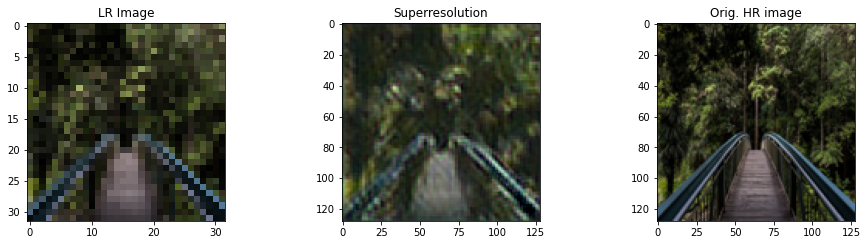

In [40]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [42]:
# import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_dataset(dataset_dir, sr_dir, resize_shape=(128,128)):
    psnr_values = []
    ssim_values = []
    mse_values = []

    for filename in os.listdir(dataset_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            hr_image = cv2.imread(os.path.join(dataset_dir, filename))
            sr_image = cv2.imread(os.path.join(sr_dir, filename))
            hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
            sr_image = cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB)

            hr_image = cv2.resize(hr_image, resize_shape)
            sr_image = cv2.resize(sr_image, resize_shape)

            psnr = peak_signal_noise_ratio(hr_image, sr_image)
            ssim = structural_similarity(hr_image, sr_image, multichannel=True)
            mse = np.mean((hr_image - sr_image) ** 2)

            psnr_values.append(psnr)
            ssim_values.append(ssim)
            mse_values.append(mse)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_mse = np.mean(mse_values)

    print(f'Average PSNR: {avg_psnr:.2f}')
    print(f'Average SSIM: {avg_ssim:.2f}')
    print(f'Average MSE: {avg_mse:.2f}')

# Example usage
evaluate_dataset('HR1/lr1', 'HR1/HR', resize_shape=(128,128))

C:\Users\admin\AppData\Local\Temp\ipykernel_14976\3834729049.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(hr_image, sr_image, multichannel=True)


Average PSNR: 21.19
Average SSIM: 0.62
Average MSE: 65.59


In [43]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity

def evaluate_image(hr_image, sr_image):
    hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
    sr_image = cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB)

    psnr = peak_signal_noise_ratio(hr_image, sr_image)
    mse = np.mean((hr_image - sr_image) ** 2)
    ssim = structural_similarity(hr_image, sr_image, multichannel=True)

    return psnr, mse, ssim

def display_images_with_metrics(dataset_dir, sr_dir):
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            hr_image = cv2.imread(os.path.join(dataset_dir, filename))
            # Resize the high-resolution image to match the dimensions of the super-resolution image
            sr_image = cv2.imread(os.path.join(sr_dir, filename))
            hr_image = cv2.resize(hr_image, (sr_image.shape[1], sr_image.shape[0]))
            
            psnr, mse, ssim = evaluate_image(hr_image, sr_image)

            print(f'Filename: {filename}, PSNR: {psnr:.2f}, MSE: {mse:.2f}, SSIM: {ssim:.2f}')

            cv2.imshow('HR Image', hr_image)
            cv2.imshow('SR Image', sr_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

# Example usage
display_images_with_metrics('HR1/lr1', 'HR1/HR')

C:\Users\admin\AppData\Local\Temp\ipykernel_14976\478753859.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(hr_image, sr_image, multichannel=True)


Filename: 0.png, PSNR: 20.38, MSE: 85.25, SSIM: 0.52
Filename: 1.png, PSNR: 25.03, MSE: 19.20, SSIM: 0.91
Filename: 10.png, PSNR: 24.09, MSE: 62.28, SSIM: 0.61
Filename: 11.png, PSNR: 19.39, MSE: 69.02, SSIM: 0.63
Filename: 12.png, PSNR: 20.06, MSE: 68.95, SSIM: 0.66
Filename: 13.png, PSNR: 24.53, MSE: 31.94, SSIM: 0.79
Filename: 14.png, PSNR: 20.80, MSE: 80.48, SSIM: 0.56
Filename: 15.png, PSNR: 23.43, MSE: 62.06, SSIM: 0.65
Filename: 16.png, PSNR: 20.84, MSE: 66.75, SSIM: 0.59
Filename: 17.png, PSNR: 19.85, MSE: 63.41, SSIM: 0.64
Filename: 18.png, PSNR: 20.84, MSE: 78.85, SSIM: 0.56
Filename: 19.png, PSNR: 18.41, MSE: 87.11, SSIM: 0.47
Filename: 2.png, PSNR: 22.06, MSE: 61.57, SSIM: 0.73
Filename: 20.png, PSNR: 15.21, MSE: 100.95, SSIM: 0.43
Filename: 21.png, PSNR: 21.35, MSE: 84.12, SSIM: 0.49
Filename: 22.png, PSNR: 21.01, MSE: 54.27, SSIM: 0.68
Filename: 23.png, PSNR: 18.43, MSE: 67.94, SSIM: 0.56
Filename: 24.png, PSNR: 17.53, MSE: 86.68, SSIM: 0.46
Filename: 25.png, PSNR: 20.44,

In [63]:
#unsharp masking
#import libraries
from PIL import Image
import numpy as np
import cv2
import math
#read image
img = cv2.imread('HR1/HR/78.png') 
#blur the image using gaussian blur
gaussian = cv2.GaussianBlur(img, (7, 7),0)
#store images as arrays
img=np.asarray(img)
gaussian=np.asarray(gaussian)
#subtract blurred image from original, then add to original
img_unsharp=img+(img-gaussian)
#output unsharp image
cv2.imwrite('output/saved_img.png', img_unsharp)
#convert array to image
img_unsharp=Image.fromarray(img_unsharp)
img_unsharp.show()

In [62]:
#contrast stretching
from PIL import Image

# Method to process the red band of the image
def normalizeRed(intensity):
    iI      = intensity
    minI    = 86
    maxI    = 230
    minO    = 0
    maxO    = 255
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO
# Method to process the green band of the image
def normalizeGreen(intensity):
    iI      = intensity
    minI    = 90
    maxI    = 225
    minO    = 0
    maxO    = 255
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO

# Method to process the blue band of the image
def normalizeBlue(intensity):
    iI      = intensity   
    minI    = 100
    maxI    = 210
    minO    = 0
    maxO    = 255
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO

#Create an image object
imageObject     = Image.open("HR1/HR/78.png")
# Split the red, green and blue bands from the Image
multiBands      = imageObject.split()
# Apply point operations that does contrast stretching on each color band
normalizedRedBand      = multiBands[0].point(normalizeRed)
normalizedGreenBand    = multiBands[1].point(normalizeGreen)
normalizedBlueBand     = multiBands[2].point(normalizeBlue)
# Create a new image from the contrast stretched red, green and blue brands
normalizedImage = Image.merge("RGB", (normalizedRedBand, normalizedGreenBand, normalizedBlueBand))
# Display the image before contrast stretching
imageObject.show()

In [55]:
# Display the image after contrast stretching
normalizedImage.show()